# CmmD: Continual Multiplex network Module Detector

Python implementation of the algorithm originally proposed in ["The multilayer community structure of medulloblastoma" by Iker Núñez-Carpintero et. al.](https://www.sciencedirect.com/science/article/pii/S2589004221003333).

Implementation relies on [MolTi-DREAM](https://github.com/gilles-didier/MolTi-DREAM) for communities detection problem.

* Make sure to add molti-console as an executable program from any directory by adding it to your ~/.bashrc file. (This file may change depending on your OS ditribution)

## 0. Import libraries and define paths

In [1]:
import os
import sys
import subprocess
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import pickle
from pathlib import Path
import pathlib
import time

Auxiliary function to measure the execution time:

In [2]:
def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time = end_time - start_time
        minutes = int(execution_time // 60)
        seconds = execution_time % 60
        print(f"Function '{func.__name__}' executed in {minutes} minutes, {seconds:.2f} seconds")
        return result
    return wrapper

## 1. Define function for community detection

In [3]:
@time_it
def communities_detection(input_layers:list[str]=None,
                          gamma_min:float=None,
                          gamma_max:float=None,
                          gamma_step:float=None,
                          path_to_communities:str=None,
                          method:str="molti"):
    # Prepare inputs to generate the console order for MolTi's run.
    layers = " ".join(input_layers)
    
    resolution_gamma_step = np.arange(gamma_min, gamma_max + gamma_step, gamma_step)
    desfile_vector = [f"{path_to_communities}{res}.csv" for res in resolution_gamma_step]
    
    # community analysis
    if method == "molti":
        for i, current_resolution in enumerate(resolution_gamma_step):
            current_destfile = desfile_vector[i]
            system_order = f"molti-console -o {current_destfile} -p {current_resolution} {layers} > /dev/null"
            subprocess.run(system_order, shell=True)

In [4]:
@time_it
def continual_multiplex_analysis(nodelist:list[str]=None,
                                 path_to_communities:str=None,
                                 distmethod:str="hamming",
                                 n_jobs:int=1):
        # reading MolTi output files
        output_files = [f for f in os.listdir(path_to_communities) if "_" not in f]
        
        alllists = []
        
        for output_file in output_files:
            with open(os.path.join(path_to_communities, output_file), 'r') as file:
                red = file.readlines()
            
            cluster_ids = [i for i, line in enumerate(red) if "Cluster" in line]
            lista = []
            
            for j, st in enumerate(cluster_ids):
                if j == len(cluster_ids) - 1:
                    en = len(red)
                else:
                    en = cluster_ids[j + 1]
                current_cluster = red[st:en]
                current_cluster2 = current_cluster[:-2] if j != len(cluster_ids) - 1 else current_cluster[:-1]
                lista.append(current_cluster2[1:])
            
            alllists.append(lista)
        
        allgenes = list(set([gene for sublist in alllists for cluster in sublist for gene in cluster]))

        if nodelist:
            allgenes = list(set(allgenes).intersection(nodelist))
        
        # Calculating Gene/Community matrix
        res_matrix = np.zeros((len(allgenes), len(alllists) + 1), dtype=int)
        gene_indices = {gene: idx for idx, gene in enumerate(allgenes)}
        
        for j, output_file_list in enumerate(alllists):
            for k, cluster in enumerate(output_file_list):
                for gene in cluster:
                    res_matrix[gene_indices[gene], j] = k + 1
        
        patterns = ["_".join(map(str, res_matrix[i, :-1])) for i in range(len(allgenes))]
        res_matrix[:, -1] = np.array(patterns, dtype=str)
        
        # porcentajes = np.linspace(0, 100, num=21)
        # for i, percentage in enumerate(np.round(np.linspace(0, 100, len(allgenes)), 4)):
        #     if percentage in porcentajes:
        #         print(f"Progress: {percentage}%")
        
        # Calculating Hamming distances for all gene pairs
        gene_community_matrix = res_matrix[:, :-1].astype(int)
        genes_same_communities = {pattern: [] for pattern in np.unique(gene_community_matrix[:,-1])}
        
        for i, pattern in enumerate(gene_community_matrix[:,-1]):
            genes_same_communities[pattern].append(allgenes[i])
        
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            distance_matrix = squareform(pdist(gene_community_matrix, metric=distmethod))
        
        final_output = {
            "gene_community_matrix": gene_community_matrix,
            "l_constant": genes_same_communities,
            "distance_matrix": distance_matrix
        }
        
        return final_output

In [5]:
def cmmd(nodelist:list[str]|None=None,
         input_layers:list[str]=None,
         gamma_min:float=None,
         gamma_max:float=None,
         gamma_step:float=None, 
         distmethod:str="hamming",
         method:str="molti",
         n_jobs:int=1,
         path_to_communities:str=None):
    
    """
    Compute CmmD multilayer community trajectory analysis for a set of given networks.

    Parameters
    ----------
    nodelist : list, optional
        A list with the unique nodes that we want to appear in the final output. If not given,
        all nodes of the multiplex will be in the final output (nodelist= NULL)
    input_layers : list
        A vector of strings containing the paths where the different network layers are located
        in the system. Networks should be a two column file representing the edges of the graph.
    gamma_min : float
        The first gamma resolution parameter to use in the different MolTi's analysis
    gamma_max : float
        The last gamma resolution parameter to use in the different MolTi's analysis.
    gamma_step : float
        The gamma_step of the resolution parameter to use. 
    distmethod : str, optional
        A distance method metric to use to compute the trajectories. Defaults to "hamming" for hamming
        distance, but accepts any other metric supplied by scipy.spatial.distance.pdist.
    n_jobs : int, optional
        The number of n_jobs to use for the computation of the distance matrix. Defaults to 1.
    path_to_communities : str, optional
        The path to save Molti's output files. Defaults to "Output/".

    Returns
    -------
    A dictionary containing the following keys:
        gene_community_matrix: A matrix where the rows correspond to the different genes, and the columns to the different community structures. The values of the matrix are the cluster to which the gene belongs in the corresponding community structure.
        l_constant: A dictionary where the keys are the different community structures, and the values are the list of genes that belong to that community structure.
        distance_matrix: A matrix with the hamming distances between all pairs of genes.
    """
    # 0. check input correctness
    if input_layers is None or len(input_layers) < 1:
        raise ValueError("ERROR: Input_layers argument must be a list of at least 1 network file")
    
    if not isinstance(gamma_max, (int, float)):
        raise ValueError("ERROR: Resolution parameter must be a number")
    
    if not isinstance(gamma_min, (int, float)):
        raise ValueError("ERROR: Resolution parameter must be a number")
    
    if not isinstance(gamma_step, (int, float)):
        raise ValueError("ERROR: gamma_step value must be a number")
    
    if not isinstance(path_to_communities, str):
        raise ValueError("ERROR: path_to_communities expects a character string")
    
    assert distmethod in ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
                          'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
                          'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis',
                          'matching', 'minkowski', 'rogerstanimoto', 'russellrao',
                          'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
                          'yule']
    
    if not isinstance(n_jobs, int):
        raise ValueError("ERROR: n_jobs must be a number corresponding to the number of cores available to use")

    # 1st part: community detection
    communities_detection(input_layers=input_layers, gamma_min=gamma_min, gamma_max=gamma_max,
                          gamma_step=gamma_step, method=method, path_to_communities=path_to_communities)
    
    # 2nd part: cmmd
    final_output = continual_multiplex_analysis(nodelist=nodelist,
                                                path_to_communities=path_to_communities,
                                                distmethod=distmethod,
                                                n_jobs=n_jobs)
    
    return final_output

In [6]:
prefix = "../data/bsc_baseline_tiny/"
input_layers = [prefix + "1.csv",
                prefix + "2.csv"]

for l in input_layers:
    assert Path(l).exists()

cmmd_output = cmmd(nodelist = None,
     input_layers = input_layers,
     gamma_min = 0,
     gamma_max = 2,
     gamma_step = 0.5,
     path_to_communities = "../out/communities/",
     distmethod = "hamming",
     n_jobs = 6)


Function 'communities_detection' executed in 0 minutes, 34.06 seconds
Function 'continual_multiplex_analysis' executed in 0 minutes, 0.21 seconds


Save object to the disk:

In [7]:
# # save object to file
# path_save = Path("../out/cmmd_pickle/")
# assert path_save.exists()

# # pickle the object
# with open(path_save / "cmmd_output.pkl", 'wb') as handle:
#     pickle.dump(cmmd_output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# def test_cmmd(cmmd:dict, path_save:pathlib.Path|str=Path("../out/cmmd_pickle/cmmd_output.pkl")) -> None:
#     # load the cmmd object
#     with open(path_save, 'rb') as handle:
#         cmmd_old = pickle.load(handle)
#     assert (cmmd["distance_matrix"] == cmmd_old["distance_matrix"]).all()
#     assert (cmmd["gene_community_matrix"] == cmmd_old["gene_community_matrix"]).all()
#     assert cmmd["l_constant"] == cmmd_old["l_constant"]

Confirm new and old objects generate the same output:

In [9]:
#| eval: false
cmmd_output.keys()

dict_keys(['gene_community_matrix', 'l_constant', 'distance_matrix'])

In [10]:
#| eval: false
for key in cmmd_output.keys():
    print(key)
    print(cmmd_output[key])
    print("*" * 20)

gene_community_matrix
[[938 924 983 960 901]
 [736 751 644 860 901]
 [951 941 930 947 901]
 ...
 [848 986 961 896 901]
 [789 924 971 944 901]
 [951 941 930 947 901]]
********************
l_constant
{np.int64(20): ['SLC18A1\n', 'DDC\n'], np.int64(60): ['RDH13\n'], np.int64(126): ['OAT\n'], np.int64(143): ['SLC6A19\n', 'SLC6A14\n', 'SLC43A2\n'], np.int64(168): ['TYR\n', 'SLC7A8\n', 'TH\n'], np.int64(195): ['HS3ST3A1\n'], np.int64(227): ['CYP2D6\n'], np.int64(239): ['CYP2C9\n'], np.int64(308): ['SLC9A4\n'], np.int64(443): ['HACD1\n'], np.int64(448): ['GCSH\n'], np.int64(450): ['NDUFAB1\n', 'NDUFAF7\n'], np.int64(466): ['NDUFA5\n'], np.int64(478): ['NDUFC1\n'], np.int64(482): ['SARDH\n', 'CHDH\n'], np.int64(514): ['DLAT\n'], np.int64(522): ['SLC36A4\n'], np.int64(553): ['SLC5A10\n', 'SLC2A6\n'], np.int64(582): ['DAO\n'], np.int64(588): ['KCNQ4\n'], np.int64(589): ['ADAMTS16\n'], np.int64(590): ['SLITRK1\n'], np.int64(591): ['HCN1\n'], np.int64(592): ['KCNG2\n'], np.int64(593): ['MYL6\n', '

In [11]:
#| eval: false
cmmd_output["distance_matrix"].shape

(5609, 5609)

In [12]:
#| eval: false
dm = cmmd_output["distance_matrix"]
dm

array([[0. , 0.8, 0.8, ..., 0.8, 0.6, 0.8],
       [0.8, 0. , 0.8, ..., 0.8, 0.8, 0.8],
       [0.8, 0.8, 0. , ..., 0.8, 0.8, 0. ],
       ...,
       [0.8, 0.8, 0.8, ..., 0. , 0.8, 0.8],
       [0.6, 0.8, 0.8, ..., 0.8, 0. , 0.8],
       [0.8, 0.8, 0. , ..., 0.8, 0.8, 0. ]])

In [13]:
#| eval: false
np.unique(dm)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

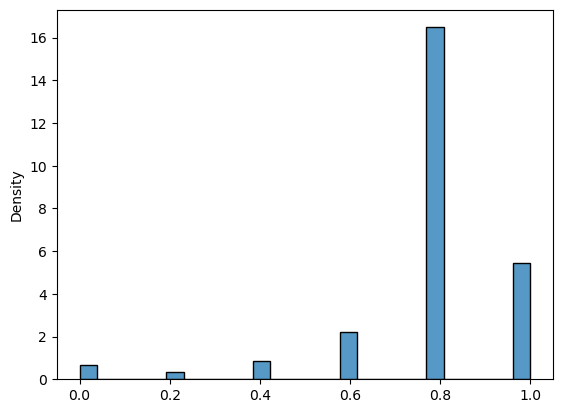

In [14]:
#| eval: false
sns.histplot(cmmd_output["distance_matrix"].flatten(), stat="density");

In [15]:
#| eval: false
gcm = cmmd_output["gene_community_matrix"]
gcm

array([[938, 924, 983, 960, 901],
       [736, 751, 644, 860, 901],
       [951, 941, 930, 947, 901],
       ...,
       [848, 986, 961, 896, 901],
       [789, 924, 971, 944, 901],
       [951, 941, 930, 947, 901]])

In [16]:
#| eval: false
gcm.shape

(5609, 5)

In [17]:
#| eval: false
l_constant = cmmd_output["l_constant"]
type(l_constant)

dict

In [18]:
#| eval: false
len(l_constant.keys())

380

In [19]:
cmmd_output.keys()

dict_keys(['gene_community_matrix', 'l_constant', 'distance_matrix'])